# All the dependencies are loaded in this section

In this section, we load all the libraries needed for the ontology building process.  
Then, we import given functions (the python files are converted into functions for a cleaner look when used in the test section). Important parameters, like minimal frequencies, are extracted as parameters to these functions.  

This section doesn't contain new code, it is only a preparatory step.  

## Library Installation

In [1]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import unicodedata
import re
import string
import tqdm.notebook as tq
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
import seaborn as sns
import seaborn as sns; sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
#option to allow infinite width on dataframe column display
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
!pip install pdfminer.six

     |████████████████████████████████| 5.6MB 2.0MB/s 
     |████████████████████████████████| 2.6MB 24.2MB/s 


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Pdf2Text

In [5]:
def pdf_2_text(path):
  from io import StringIO
  from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
  from pdfminer.converter import TextConverter
  from pdfminer.layout import LAParams
  from pdfminer.pdfpage import PDFPage
  from os.path import isfile, join
  from os import listdir
  from spacy.lang.en import English
  nlp = English()
  nlp.add_pipe(nlp.create_pipe('sentencizer'))

  def main():
      """
      An algorithm that convert a list of pdf files into text files.
      DocsDir: a directory where pdf files exists
      DataDir: a directory where you want to save the results file
      """
      DocsDir= path+"/pdf_docs"
      DataDir = path+"/Corpus"
      alldocs = [f for f in listdir(DocsDir) if isfile(join(DocsDir, f)) and f.__contains__(".pdf")]
      for doc in alldocs:
          text = convert(join(DocsDir, doc))
          of = doc.replace(".pdf", ".txt")
          f1 = open(join(DataDir, of), 'w', errors='ignore')
          p = ""
          lines = text.split("\n")
          for i, line in enumerate(lines):
              if line == "":
                  continue
              if not line.endswith(".") and (len(line.split(" ")) >= 5 or len(p.split(" ")) >= 5) and len(lines[i+1].split(" ")) > 0:
                  p += line.strip() + " "
                  continue
              elif line.endswith("."):
                  p += line
                  if len(p.split(" ")) >= 5:
                      f1.write(preprocess(p) + "\n")
                  p = ""
              else:
                  if len(line.split(" ")) >= 5:
                      f1.write(preprocess(line) + "\n")
                  p = ""

          f1.close()


  def preprocess(file_str):
      doc = nlp(file_str)
      sents = [sent.string.strip() for sent in doc.sents]
      cleaned = list(map(lambda x: x.replace('-\n', '').replace('\n', ' ').replace(u'', 'fi'), sents))
      return '\n'.join(cleaned)

  #converts pdf, returns its text content as a string
  def convert(fname, pages=None):
      if not pages:
          pagenums = set()
      else:
          pagenums = set(pages)

      output = StringIO()
      manager = PDFResourceManager()
      converter = TextConverter(manager, output, laparams=LAParams())
      interpreter = PDFPageInterpreter(manager, converter)

      infile = open(fname, 'rb')
      for page in PDFPage.get_pages(infile, pagenums):
          interpreter.process_page(page)
      infile.close()
      converter.close()
      text = output.getvalue()
      output.close()
      return ' '.join(text.split())

  if __name__ == '__main__':
      main()


#test
# path = '/content/drive/MyDrive/nantes/semantic/OL_Python'
# pdf_2_text(path)

## Corpus_Parsing.py

In [6]:
def corpus_parsing(path, min_freq):
  from os import listdir
  from os.path import isfile, join
  nlp = spacy.load('en_core_web_sm')

  def main():
      """
          corpus parsing + creation of frequent terms file above given minimum threshold
      """
      # inputs
      corpus_dir = path+"/Corpus"  #directory for corpus documents
      output_dir = path+"/OutputDir" # result file output directory
      output_file = output_dir + r"/processedTestCorpus.txt" # name of the output file (the processed corpus)
      freqTerms_output_file = output_dir + r"/freqTerms.txt" # name of the output file (the frequent terms)
      isDep = True #True for depenceny parsing; False for shallow parsing
      #Process Result: create the processed corpus file and the frequent terms file

      lemmas = dict()
      alldocs = [join(corpus_dir, f) for f in listdir(corpus_dir) if isfile(join(corpus_dir, f))]
      f2 = open(output_file, "w", errors='ignore')
      for doc in tq.tqdm(alldocs):
          f2.write("<text>" + "\n") # new document
          with open(doc, "rb")as docText:
              for line in docText:
                  f2.write("<s>" + "\n") #new sentence
                  sent = line.strip().decode("utf-8", "ignore")
                  if isDep:
                      parsedSent = nlp(sent) #dependency parsing
                  else:
                      parsedSent = nlp(sent, disable=['parser']) #shallow parsing
                  index = 0
                  for token in parsedSent:
                      if isDep:
                          w = token.text + "\t" + token.lemma_ + "\t" + token.pos_ + "\t" + str(
                              index) + "\t" + token.head.text + "\t" + token.dep_ + "\n"
                      else:
                          w = token.text + "\t" + token.lemma_  + "\t" + token.pos_ + "\t" + str(
                              index) + "\tparent\tdep\n"
                      f2.write(w) #sentence word
                      index += 1
                      lemma = token.lemma_
                      if lemma in lemmas.keys():
                          lemmas[lemma] = lemmas[lemma] + 1
                      else:
                          lemmas[lemma] = 1
                  f2.write("</s>" + "\n")
          f2.write("</text>" + "\n")

      #write the frequent lemmas into frequnet file
      freq_file = open(freqTerms_output_file, "w")
      for key in lemmas.keys():
          if lemmas[key] >= min_freq:
              freq_file.write(key + "\n")
      freq_file.close()
      f2.close()

  if __name__ == '__main__':
      main()

#test
# min_freq = 3 #minimum frequent threshold for creating the file of frequent terms
# corpus_parsing(path, min_freq)

## TermExtraction.py

In [7]:
def term_extraction(path, minFreq):
  import spacy
  from os import listdir
  from os.path import isfile, join
  nlp = spacy.load('en_core_web_sm')
  from spacy.lang.en.stop_words import STOP_WORDS
  stopWords = set(STOP_WORDS)

  def main():
      """
      document terms extraction
      """
      #inputs
      corpus_dir = path+"/Corpus" #directory for corpus documents
      output_dir = path+"/OutputDir" #result files output directory
      output_file = output_dir + r"/ExtractedTerms.txt" #the path to save the extracted terms

      terms_file = open(output_file, "w", errors='ignore')
      #compute tf for each term in the corpus
      tf= computerTf(corpus_dir)
      #if tf of the term is greater than minimum freq save it to the output file
      for term, score in tf.items():
          if score >= minFreq:
              terms_file.write(str(term) + "\n")

  def removeArticles(text):
      #remove stop words from the begining of a NP
      words = text.split()
      if words[0] in stopWords:
          return text.replace(words[0]+ " ", "")
      return text

  def computerTf(dir):
      alldocs = [join(dir, f) for f in listdir(dir) if isfile(join(dir, f))]
      AllTerms = dict()
      for doc in tq.tqdm(alldocs):
          docText = open(doc, "r", errors='ignore').read()
          docParsing = nlp(docText)
          for chunk in docParsing.noun_chunks:
              np = removeArticles(chunk.text.lower())
              if np in stopWords:
                  continue
              if np in AllTerms.keys():
                  AllTerms[np] += 1
              else:
                  AllTerms[np] = 1

      return AllTerms

  if __name__ == '__main__':
      main()

# test
# minFreq = 5 #minimum frequency threshold
# term_extraction(path, minFreq)

##Common Function import

In [8]:
import gzip
import string
import numpy as np
from collections import defaultdict

def get_sentences(corpus_file):
    """
    Returns all the (content) sentences in a corpus file
    :param corpus_file: the corpus file
    :return: the next sentence (yield)
    """

    # Read all the sentences in the file
    with open(corpus_file, 'r', errors='ignore') as f_in:

        s = []

        for line in f_in:
            line = line

            # Ignore start and end of doc
            if '<text' in line or '</text' in line or '<s>' in line:
                continue
            # End of sentence
            elif '</s>' in line:
                yield s
                s = []
            else:
                try:
                    word, lemma, pos, index, parent, dep = line.split()
                    s.append((word, lemma, pos, int(index), parent, dep))
                # One of the items is a space - ignore this token
                except Exception as e:
                    print (str(e))
                    continue

def save_file_as_Matrix12(cooc_mat, frequent_contexts, output_Dir, MatrixFileName, MatrixSamplesFileName):
    print(len(frequent_contexts))
    cnts = ["Terms/contexts"]
    list_of_lists = []
    for context in frequent_contexts:
        cnts.append(context)
    list_of_lists.append(cnts)
    for target, contexts in cooc_mat.items():
        targets = []
        targets.append(target)
        for context in frequent_contexts:
            if context in contexts.keys():
                targets.append(str(contexts[context]))
            else:
                targets.append(str(0))
        list_of_lists.append(targets)
    res = np.array(list_of_lists)
    np.savetxt(output_Dir + MatrixFileName, res, delimiter=",", fmt='%s')
    return

def save_file_as_Matrix1(cooc_mat, frequent_contexts, output_Dir, MatrixFileName, MatrixSamplesFileName):
    f = open(output_Dir + MatrixSamplesFileName, "w")
    list_of_lists = []
    for target, contexts in cooc_mat.items():
        targets = []
        f.write(target+"\n")
        for context in frequent_contexts:
            if context in contexts.keys():
                targets.append(contexts[context])
            else:
                targets.append(0)
        list_of_lists.append(targets)
    res = np.array(list_of_lists)
    np.savetxt(output_Dir + MatrixFileName, res, delimiter=",")
    return

def save_file_as_Matrix2(cooc_mat, frequent_contexts, output_Dir, MatrixFileName, frequent_couples):
    list_of_lists = []
    cnts = ["NP_couples/contexts"]
    for context in frequent_contexts:
        cnts.append(context)
    list_of_lists.append(cnts)
    for target, contexts in cooc_mat.items():
        if target in frequent_couples:
            targets = []
            targets.append(str(target).replace("\t", " ## "))
            for context in frequent_contexts:
                if context in contexts.keys():
                    targets.append(str(contexts[context]))
                else:
                    targets.append(str(0))
            list_of_lists.append(targets)
    res = np.array(list_of_lists)
    np.savetxt(output_Dir + MatrixFileName, res, delimiter=",", fmt='%s')
    return

def save_file_as_Matrix(cooc_mat, frequent_contexts, output_Dir, MatrixFileName, MatrixSamplesFileName, frequent_couples):
    f = open(output_Dir + MatrixSamplesFileName, "w")
    list_of_lists = []
    for target, contexts in cooc_mat.items():
        if target in frequent_couples:
            targets = []
            f.write(target+"\n")
            for context in frequent_contexts:
                if context in contexts.keys():
                    targets.append(contexts[context])
                else:
                    targets.append(0)
            list_of_lists.append(targets)
    res = np.array(list_of_lists)
    np.savetxt(output_Dir + MatrixFileName, res, delimiter=",")
    return

def filter_couples(cooc_mat, min_occurrences):
    """
    Returns the couples that occurred at least min_occurrences times
    :param cooc_mat: the co-occurrence matrix
    :param min_occurrences: the minimum number of occurrences
    :return: the frequent couples
    """

    couple_freq = []
    for target, contexts in cooc_mat.items():
        occur = 0
        for context, freq in contexts.items():
            occur += freq
        if occur >= min_occurrences:
            couple_freq.append(target)
    return couple_freq

def filter_contexts(cooc_mat, min_occurrences):
    """
    Returns the contexts that occurred at least min_occurrences times
    :param cooc_mat: the co-occurrence matrix
    :param min_occurrences: the minimum number of occurrences
    :return: the frequent contexts
    """
    context_freq = defaultdict(int)
    for target, contexts in cooc_mat.items():
        for context, freq in contexts.items():
            try:
                str(context)
                context_freq[context] = context_freq[context] + freq
            except:
                continue

    frequent_contexts = set([context for context, frequency in context_freq.items() if frequency >= min_occurrences and context not in string.punctuation])
    return frequent_contexts

def getSentence(strip_sentence):
    """
            Returns sentence (space seperated tokens)
            :param strip_sentence: the list of tokens with other information for each token
            :return: the sentence as string
    """
    sent = ""
    for i, (t_word, t_lemma, t_pos, t_index, t_parent, t_dep) in enumerate(strip_sentence):
        sent += t_word.lower() + " "
    return sent

## window_based_matrix_creation.py

In [9]:
def window_based_matrix_creation(path, MIN_FREQ):
  import os
  from collections import defaultdict


  def main():
      """
      Create window-based co-occurence file
      """
      processed_corpus_dir = path+"/OutputDir"
      freq_file = processed_corpus_dir+"/freqTerms.txt"
      terms_file = processed_corpus_dir+"/ExtractedTerms.txt"
      window_size = 5

      # Load the frequent words file
      with open(freq_file) as f_in:
          freq_words = set([line.strip() for line in f_in])
      with open(terms_file) as f_in2:
          terms = set([line.strip() for line in f_in2])

      cooc_mat = defaultdict(lambda: defaultdict(int))

      corpus_files = sorted([processed_corpus_dir + '/' + file for file in os.listdir(processed_corpus_dir) if str(file).__contains__("processed")])

      for file_num, corpus_file in enumerate(corpus_files):

          print('Processing corpus file %s (%d/%d)...' % (corpus_file, file_num + 1, len(corpus_files)))
          for sentence in tq.tqdm(get_sentences(corpus_file)):
              update_window_based_cooc_matrix(cooc_mat, freq_words, sentence, window_size, terms)

      # Filter contexts to decrease sparsity
      frequent_contexts = filter_contexts(cooc_mat, MIN_FREQ)
      # Save the files
      save_file_as_Matrix1(cooc_mat, frequent_contexts, processed_corpus_dir, r"/window_matrix.csv", r"/window_matrix_terms.txt")
      save_file_as_Matrix12(cooc_mat, frequent_contexts, processed_corpus_dir, r"/window_matrix2.csv", r"/window_matrix_terms.txt")

  def update_window_based_cooc_matrix(cooc_mat, freq_words, sentence, window_size, terms):
      """
      Updates the co-occurrence matrix with the current sentence
      :param cooc_mat: the co-occurrence matrix
      :param freq_words: the list of frequent words
      :param sentence: the current sentence
      :param window_size: the number of words on each side of the target
      :param directional: whether to distinguish between contexts before and after the target
      :return: the update co-occurrence matrix
      """

      # Remove all the non relevant words, keeping only NN, JJ and VB
      strip_sentence = [(w_word, w_lemma, w_pos, w_index, w_parent, w_dep) for
                        (w_word, w_lemma, w_pos, w_index, w_parent, w_dep) in sentence
              if str(w_pos).__eq__('NOUN') or str(w_pos).__eq__('PROPN') or str(w_pos).__eq__('VERB') or str(w_pos).__eq__('ADJ')]

      sent = getSentence(strip_sentence)
      for term in terms:
          ln = len(term.strip().split())
          Indexes = getIndexes(sent, term)
          for i in Indexes:
              if i > 0:
                  for l in range(max(0, i - window_size), i):
                      _, c_lemma, c_pos, _, _, _ = strip_sentence[l]

                      if c_lemma not in freq_words:
                          continue

                      context = c_lemma  # context lemma + left + lower pos
                      cooc_mat[term][context] = cooc_mat[term][context] + 1
              # Update right contexts if they are inside the window and before EOS (and frequent enough)
              for r in range(i + ln, min(len(strip_sentence), i + ln + window_size)):

                  _, c_lemma, c_pos, _, _, _ = strip_sentence[r]

                  if c_lemma not in freq_words:
                      continue

                  context = c_lemma
                  cooc_mat[term][context] = cooc_mat[term][context] + 1

      return cooc_mat

  def getIndexes(sent, term):
      """
          Returns all indexes where a term occurs in a sentence
          :param sent: a sentence (space separated words)
          :param term: the term
          :return: list of indexes where the term occurs in the sentence
      """
      indexes = []
      if (" " + sent).__contains__( " " + term + " "):
          term2 = term.replace(" ", "_")
          sent = sent.replace(" " + term + " ", " " + term2 + " ")
          twords = [t for t in term2.strip().split()]
          swords = [st for st in sent.strip().split()]
          ln = len(term.strip().split()) - 1
          word = twords[0]
          while True:
              try:
                  ind = swords.index(word)
                  indlen = len(indexes)
                  indexes.append(ind + (indlen * ln))
                  swords[ind] = "_"
              except:
                  break
      return indexes


  if __name__ == '__main__':
      main()

#test
# MIN_FREQ = 20
# window_based_matrix_creation(path, MIN_FREQ)

## Matrix Sparsity

In [10]:
def matrix_sparsity(path):
  import matplotlib.pyplot as plt
  import numpy as np

  def main():
      X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",")
      sparsity = 1.0 - np.count_nonzero(X) * 1.0 / X.size
      print(sparsity)
      plt.matshow(X)
      plt.show()

  if __name__ == '__main__':
      main()

#test
# matrix_sparsity(path)

## Kmeans clustering

In [11]:
def kmeans_clustering(path, nbClusters):
  from sklearn.cluster import KMeans
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.decomposition import PCA

  def main():
      
      #load the data
      X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",")
      #data shuffling
      # np.random.shuffle(X)
      #apply k-means
      kmeans = KMeans(n_clusters=nbClusters, random_state=0).fit_predict(X)
      print(kmeans)
      plt.figure()
      X = PCA(n_components=2).fit_transform(X)
      plt.scatter(X[:, 0], X[:, 1], c=kmeans)
      plt.show()
      clusters = dict()
      for i in range(0, nbClusters):
          clusters[i] = []
      i = 0
      #get the clusters
      with open(path+"/OutputDir/window_matrix_terms.txt", "r") as f:
          for line in f:
              term = line.strip()
              clusterNb = kmeans[i]
              i += 1
              clusters[clusterNb].append(term)
      for cluster_id, cluster  in clusters.items():
          print("cluster: " + str(cluster_id))
          print(cluster)

  if __name__ == '__main__':
      main()

#test
# nbClusters = 5 #number of clusters
# kmeans_clustering(path)

## Core-concept-based clustering

In [12]:
def core_concept_based_clustering(path, CoreConcepts):
  from sklearn.metrics.pairwise import cosine_similarity
  import numpy as np


  def main():
      #load the matrix and the terms of the matrix
      X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",")
      Y = np.loadtxt(path+"/OutputDir/window_matrix_terms.txt", delimiter="\t", dtype=str)

      coreConceptsDict = dict()
      coreConceptsSpecializationDict = {core:[] for core in CoreConcepts}
      otherConceptsDict = dict()
      i = 0
      #seperate the matirx data between core concepts data and other concepts data
      for y in Y:
          if y in CoreConcepts:
              coreConceptsDict[y] = X[i]
          else:
              otherConceptsDict[y] = X[i]
          i += 1

      #calculate the similarity between each other concept and each concept
      # then attach other concept to the core concept with highest similarity
      for con, x in otherConceptsDict.items():
          maxVal = 0
          conCluster = ""
          for coreCon, y in coreConceptsDict.items():
              val = cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))
              if val > maxVal:
                  maxVal = val
                  conCluster = coreCon
          if conCluster != "": #added condition as recommended by other students
            coreConceptsSpecializationDict[conCluster].append(con)
          # coreConceptsSpecializationDict[conCluster].append(con)

      for core_concept, cluster in coreConceptsSpecializationDict.items():
          print("cluster: " + core_concept)
          print(cluster)



  if __name__ == '__main__':
      main()

#test
#initialize the core concepts
# CoreConcepts = ["navy", "war", "ship"]
# core_concept_based_clustering(path, CoreConcepts)

## KNN

In [13]:
def KNN(path):
  import numpy as np
  from sklearn.metrics import accuracy_score

  def main():
      #load the data and labels
      X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",", dtype=float)
      Y = np.loadtxt(path+"/InputDir/window_matrix_terms_labeled.txt", delimiter=",", dtype=str)
      #split the data between training and testing
      from sklearn.model_selection import train_test_split
      data_train, data_test, labels_train, labels_test, couples_train, couples_test = train_test_split(X, Y[:, 1], Y[:, 0], test_size=0.20)

      #build the Knn model
      from sklearn.neighbors import KNeighborsClassifier
      neigh = KNeighborsClassifier(n_neighbors=3)
      neigh.fit(data_train, labels_train)

      #predict for the testing data
      y = neigh.predict(data_test)
      #pring the results
      print ("accuracy:")
      print (accuracy_score(labels_test, y))
      i = 0
      for couple in couples_test:
          if int(y[i]) - int(labels_test[i]) == 0:
              print(couple + ", " + str(labels_test[i]) + ", " + str(y[i]))
          else:
              print(couple + ", " + str(labels_test[i]) + ", " + str(y[i]))
          i += 1


  if __name__ == '__main__':
      main()

#test
# KNN(path)

# Ontology building

In this section, we use all the previously imported functions on the dataset.  
First, we make a quick analysis of the texts provided to know how to package them and what terms to look for (domain analysis). 

Then, we perform term analysis by extracting frequent words, then frequent terms that might be related to the domain.

Next steps are the co-occurence matrix building to get matrix sparsity of these terms relative to their occurence in a sentence.

The final steps are the analysis of the matrix through clustering (unsupervised) and classification (supervised) algorithms.  

In [14]:
corpus_path = '/content/drive/MyDrive/nantes/semantic/computerScienceCorpus'
abstract_filename = '/TP_CS_Abstract.csv'
subcore_concepts_filename = '/TP_CS_CoreConceptIn2Level.csv'
core_concepts_filename = '/TP_CS_CoreConcepts.csv'  

In [15]:
abstract = pd.read_csv(corpus_path+abstract_filename, sep=',', header=None, names=['index2', 'text_content'])
abstract.drop('index2', axis=1, inplace=True)
abstract

,text_content
0,"(2 + 1)-dimensional non-linear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a (2 + 1)-dimensional non-linear Schrodinger equation coupled with the self-induced transparency equations. For such a system, via the Hirota method and symbolic computation, linear forms, one-, two-and N-soliton solutions are obtained. Asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic. Bright solitons are obtained for the fields E and P, while the dark ones for the field N, with E as the electric field, P as the polarization in the resonant medium induced by the electric field, and N as the population inversion profile of the dopant atoms. Head-on interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen. Influence of the averaged natural frequency. on the solitons are studied: (1). can affect the velocities of all the solitons; (2) Amplitudes of the solitons for the fields P and N increase with. decreasing, and decrease with. increasing; (3) With. decreasing, for the fields P and N, one-peak one soliton turns into the two-peak one, as well as interaction type changes from the interaction between two one-peak ones to that between a one-peak one and a two-peak one; (4) For the field E, influence of. on the solitons cannot be found. The results of this paper might be of potential applications in the design of optical communication systems which can produce the bright and dark solitons simultaneously."
1,"(Objective) In order to increase classification accuracy of tea-category identification (TCI) system, this paper proposed a novel approach. (Method) The proposed methods first extracted 64 color histogram to obtain color information, and 16 wavelet packet entropy to obtain the texture information. With the aim of reducing the 80 features, principal component analysis was harnessed. The reduced features were used as input to generalized eigenvalue proximal support vector machine (GEPSVM). Winner-takes-all (WTA) was used to handle the multiclass problem. Two kernels were tested, linear kernel and Radial basis function (RBF) kernel. Ten repetitions of 10-fold stratified cross validation technique were used to estimate the out-of-sample errors. We named our method as GEPSVM + RBF + WTA and GEPSVM + WTA. (Result) The results showed that PCA reduced the 80 features to merely five with explaining 99.90% of total variance. The recall rate of GEPSVM + RBF + WTA achieved the highest overall recall rate of 97.9%. (Conclusion) This was higher than the result of GEPSVM + WTA and other five state-of-the-art algorithms: back propagation neural network, RBF support vector machine, genetic neural-network, linear discriminant analysis, and fitness-scaling chaotic artificial bee colony artificial neural network."
2,"[Purpose] This study verified that the smoothness of reaching movements is able to quantitatively evaluate the effects of two-and three-dimensional images on movement in healthy people. In addition, clinical data of cerebrovascular accident patients were also analyzed by the same method. [Subjects] Ten healthy adult volunteers and two male patients with previous cerebrovascular accidents participated. [Methods] The subjects were tasked with reaching for objects shown on a display. The target and virtual limb, rendered with computer graphics, were shown on the display. Movements of the virtual limb were synchronized with those of the subject. Healthy subjects reached for targets with their dominant arm, and cerebrovascular accident patients used their paretic arm. A polarized display and polarized glasses were used when the subjects were shown three-dimensional images. In the present study, jerk cost was used to quantify the smoothness of movement. [Results] Six of the 10 healthy subjects had significantly smoother reaching movements when viewing the three-dimen

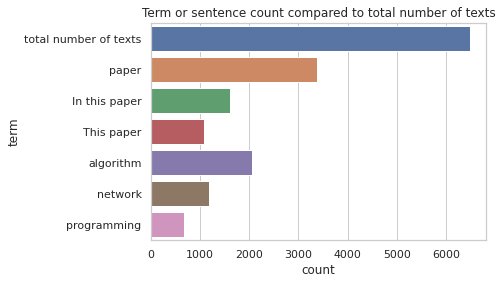

In [16]:
word_stat_list = [
 ['total number of texts',abstract.text_content.str.contains('').sum()],
 ['paper', abstract.text_content.str.contains('paper').sum()],
 ['In this paper',abstract.text_content.str.contains('In this paper').sum()],
 ['This paper', abstract.text_content.str.contains('This paper').sum()],
 ['algorithm', abstract.text_content.str.contains('algorithm').sum()],
 ['network', abstract.text_content.str.contains('network').sum()],
 ['programming', abstract.text_content.str.contains('programming').sum()],
 ]

word_stat_df = pd.DataFrame(word_stat_list, columns=['term', 'count'])

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="count", y="term", data=word_stat_df)
plt.title('Term or sentence count compared to total number of texts')

plt.show()

## Corpus metrics

How many words are present in the dataset ?

In [17]:
abstract['text_len'] = abstract.apply(lambda row: len(row.text_content.split(' ')), axis=1)
print('Total number of words : ' + str(abstract.text_len.sum()))

Total number of words : 1179868


How many words are there per text ?

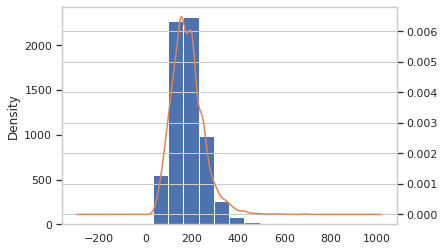

In [18]:
kde_ax = abstract.text_len.plot(kind='hist')
abstract.text_len.plot(kind='kde', ax=kde_ax, secondary_y=True)

In [19]:
def count_numbers(s):
  return sum(c.isdigit() for c in s)

def count_letters(s):
  return sum(c.isalpha() for c in s)

abstract['letter_count'] = abstract.apply(lambda row: count_letters(row.text_content), axis=1)
abstract['number_count'] = abstract.apply(lambda row: count_numbers(row.text_content), axis=1)
abstract

,text_content,text_len,letter_count,number_count
0,"(2 + 1)-dimensional non-linear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a (2 + 1)-dimensional non-linear Schrodinger equation coupled with the self-induced transparency equations. For such a system, via the Hirota method and symbolic computation, linear forms, one-, two-and N-soliton solutions are obtained. Asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic. Bright solitons are obtained for the fields E and P, while the dark ones for the field N, with E as the electric field, P as the polarization in the resonant medium induced by the electric field, and N as the population inversion profile of the dopant atoms. Head-on interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen. Influence of the averaged natural frequency. on the solitons are studied: (1). can affect the velocities of all the solitons; (2) Amplitudes of the solitons for the fields P and N increase with. decreasing, and decrease with. increasing; (3) With. decreasing, for the fields P and N, one-peak one soliton turns into the two-peak one, as well as interaction type changes from the interaction between two one-peak ones to that between a one-peak one and a two-peak one; (4) For the field E, influence of. on the solitons cannot be found. The results of this paper might be of potential applications in the design of optical communication systems which can produce the bright and dark solitons simultaneously.",250,1267,8
1,"(Objective) In order to increase classification accuracy of tea-category identification (TCI) system, this paper proposed a novel approach. (Method) The proposed methods first extracted 64 color histogram to obtain color information, and 16 wavelet packet entropy to obtain the texture information. With the aim of reducing the 80 features, principal component analysis was harnessed. The reduced features were used as input to generalized eigenvalue proximal support vector machine (GEPSVM). Winner-takes-all (WTA) was used to handle the multiclass problem. Two kernels were tested, linear kernel and Radial basis function (RBF) kernel. Ten repetitions of 10-fold stratified cross validation technique were used to estimate the out-of-sample errors. We named our method as GEPSVM + RBF + WTA and GEPSVM + WTA. (Result) The results showed that PCA reduced the 80 features to merely five with explaining 99.90% of total variance. The recall rate of GEPSVM + RBF + WTA achieved the highest overall recall rate of 97.9%. (Conclusion) This was higher than the result of GEPSVM + WTA and other five state-of-the-art algorithms: back propagation neural network, RBF support vector machine, genetic neural-network, linear discriminant analysis, and fitness-scaling chaotic artificial bee colony artificial neural network.",193,1048,17
2,"[Purpose] This study verified that the smoothness of reaching movements is able to quantitatively evaluate the effects of two-and three-dimensional images on movement in healthy people. In addition, clinical data of cerebrovascular accident patients were also analyzed by the same method. [Subjects] Ten healthy adult volunteers and two male patients with previous cerebrovascular accidents participated. [Methods] The subjects were tasked with reaching for objects shown on a display. The target and virtual limb, rendered with computer graphics, were shown on the display. Movements of the virtual limb were synchronized with those of the subject. Healthy subjects reached for targets with their dominant arm, and cerebrovascular accident patients used their paretic arm. A polarized display and polarized glasses were used when the subjects were shown three-dimensional images. In the present study, jerk cost was used to quantify the smoothness of movement. [Results] Six of the 10 healthy subjects had significantl

In [20]:
pd.DataFrame([[abstract.letter_count.sum(), abstract.number_count.sum()]], columns=['sum of letters', 'sum of numbers'])

,sum of letters,sum of numbers
0,6665617,38677


The graph below shows the proportion of numbers to letters (special characters are not counted)

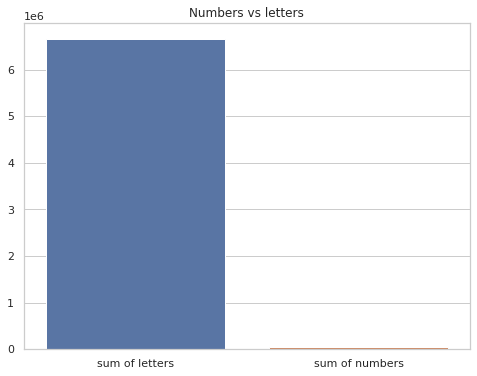

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(data=pd.DataFrame([[abstract.letter_count.sum(), abstract.number_count.sum()]], columns=['sum of letters', 'sum of numbers']))
plt.title('Numbers vs letters')
plt.show()

We load the core concepts from the original csv file given in the project files :

In [22]:
core_concepts = pd.read_csv(corpus_path+core_concepts_filename)
core_concepts

,Data structure
0,Cryptography
1,Software engineering
2,Computer graphics
3,Network security
4,Computer programming
5,Algorithm design
6,Operating systems
7,Distributed computing
8,Machine learning


We also load the sub-core-concept file given in the project files :

In [23]:
subcore_concepts = pd.read_csv(corpus_path+subcore_concepts_filename)
subcore_concepts.drop('Unnamed: 0', axis=1, inplace=True)
subcore_concepts

,level1_13CoreConcepts,level2_subCoreConcepts
0,Computer graphics,computer vision
1,Image processing,image capture
2,Image processing,image compression
3,Image processing,image enhancement
4,Image processing,image restoration
5,Image processing,image reconstruction
6,Image processing,image segmentation
7,Image processing,image representation
8,Artificial intelligence,knowledge representation
9,Artificial intelligence,machine learning


## Text corpus creation

We define two utility functions :  
*   `delete_all_files_at` allows to delete all files in a given directory
*   `split_list_every_n` creates batches of n texts from the dataframe of all the corpus. This allows to work on a subsection of the data to quickly try some parameters.

In [24]:
import os

def delete_all_files_at(path_to_delete):
  if (len(os.listdir(path_to_delete))>0):
    print('deleting files...')
    for filename in tq.tqdm(os.listdir(path_to_delete)):
      os.remove(path_to_delete+filename)
  else:
    print('no files to delete')

#test
# delete_all_files_at(path+'/Corpus')

In [25]:
def internal_split_list_every_n(df, n):
  n_rows_df, rest_df = (df[:n], df[n:]) if len(df) > n else (df, None)
  return n_rows_df, rest_df

def split_list_every_n(df, n):
  rest_df = df
  n_rows_df_list = []
  while True:
    n_rows_df, rest_df = internal_split_list_every_n(rest_df, n)
    n_rows_df_list.append(n_rows_df)
    if rest_df is None:
      break;
  return n_rows_df_list

#test creation of 4 batches
# split_list_every_n(list(core_concepts['Data structure'].values), 4)

/!\ From now on, the project paths are defined below :

Please change with your own to match the path where `computerScienceCorpus` and `computer_science` folders are located.

In [26]:
main_path = '/content/drive/MyDrive/nantes/semantic'


path = main_path+'/computer_science'
corpus_path = main_path+'/computerScienceCorpus'
abstract_filename = '/TP_CS_Abstract.csv'

Availiable dataframes are :
*   abstract
*   core_concepts
*   subcore_concepts

The function `load_abstract_and_export_to_txt` defined in the cell below loads the corpus text and saves it in txt form with each txt containing a batch of n texts aggregated.

In [27]:
def load_abstract_and_export_to_txt(corpus_path, project_path, max_batch_number):

  #delete all previously created files
  delete_all_files_at(path+'/Corpus/')

  abstract = pd.read_csv(corpus_path, sep=',', header=None, names=['index2', 'text_content'])
  abstract.drop('index2', axis=1, inplace=True)
  #first step is to extract all csv data and store it in a text file, with one file per text
  
  cpt = 0
  for bundle_of_texts in split_list_every_n(list(abstract['text_content'].values), 100)[:max_batch_number]:
    corpus_filename = project_path + '/Corpus/abstract-' +str(cpt) +'.txt'
    np.savetxt(corpus_filename,bundle_of_texts, fmt='%s')
    cpt+=1

  print('Saved corpus at : ' + corpus_filename)
  print(str(cpt) + ' Batches of 100 texts made')

load_abstract_and_export_to_txt(corpus_path + abstract_filename, path, -1)

deleting files...



Saved corpus at : /content/drive/MyDrive/nantes/semantic/computer_science/Corpus/abstract-63.txt
64 Batches of 100 texts made


## Corpus parsing - Token Extraction test

WARNING : this test lasts 30+ minutes. Uncomment to refresh the graph at your own risk.

Evaluation step : we measure how many words are extrated dependeing on minimal frequency. We can see an elbow at 12 so we keep minFreq = 8 for the next part.

Uncomment to run this section.

In [28]:
# #we try different min_freq values
# freqTerms_path = path+'/OutputDir'+'/freqTerms.txt'
# min_freq_list = [3, 5, 8, 12, 17, 23, 50] #minimum frequent threshold for creating the file of frequent terms
# len_list = []
# for min_freq in min_freq_list:
#   corpus_parsing(path, min_freq)
#   frequent_terms_df = pd.read_csv(freqTerms_path, sep='\t*', names=['term'])
#   len_list.append([min_freq, len(frequent_terms_df)])

# min_freq_len_df = pd.DataFrame(len_list, columns=['minimum frequency', 'number of extracted terms'])
# ax = min_freq_len_df.plot(x='minimum frequency', title='Extracted terms per minimum frequency in extraction process')

In [29]:
corpus_parsing(path, 50)

## Frequent term extraction test

WARNING : this test lasts 8+ minutes. Uncomment to refresh the graph at your own risk.

We can see an elbow at around frequency=8, so we will use this value from now on.

In [30]:
# #we try different min_freq values
# freqTerms_path = path+'/OutputDir'+'/ExtractedTerms.txt'
# min_freq_list = [3, 5, 8, 12, 17, 23, 50] #minimum frequent threshold for creating the file of frequent terms
# len_list = []
# for min_freq in min_freq_list:
#   term_extraction(path, min_freq)
#   frequent_terms_df = pd.read_csv(freqTerms_path, sep='\t*', names=['term'])
#   len_list.append([min_freq, len(frequent_terms_df)])

# min_freq_len_df = pd.DataFrame(len_list, columns=['minimum frequency', 'number of frequent terms'])
# ax = min_freq_len_df.plot(x='minimum frequency', title='Frequent terms per minimum frequency in extraction process')

In [31]:
term_extraction(path, 50)

## window-based matrix creation test

In the same way than previous test, we have settled on a given frequency that depends on the 2 previous frequencies (term extraction and frequent terms).  
The goal is to have a matrix as square as possible.  

In [32]:
window_based_matrix_creation(path, 800)

Processing corpus file /content/drive/MyDrive/nantes/semantic/computer_science/OutputDir/processedTestCorpus.txt (1/1)...



563


## Matrix sparsity test

0.2818096778225089


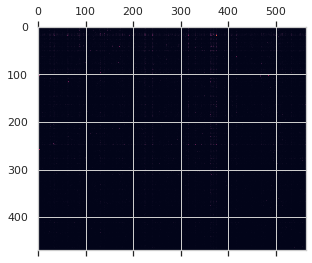

In [33]:
matrix_sparsity(path)

## Kmeans test

[ 1  1  1  1  6  6  1  1 10  1  1  6  5  1  1  3  7  5  3  7  6  1  1  3
  1  1  6  1  6  1  1  5  1  1  6  1  6  1  6  1  1  3  3  6  3  6  1  1
  6  1  5  8  1  6  3  1  2  1  1  1  1  1  1  6  1  1  3  1  6  1  1  3
  1  6  1  1  6  1  6  3  6  1  1  6  1  1  6  5  1  6  1  3  3  1  1  1
  1  6  6  1  5  1  1  9  1  1  1  1  1  6  1  1  1  1  1  1  6  1  6  6
  1  6  1  1  6  0  1  1  1  1  1  6  1  8  1  1  6  1  1  1  1  1  3  1
  1  6  6  6  1  1  6  1  1  1  1  1  1  1  6  1  1  1  1  1  3  1  6  4
  6  1  1  6  1  1  1  6  1  1  1  1  6  6  1  1  1  6  1  6  6  6  1  1
  1  1  1  1  1  1  6  1  1  1  1  6  1  1  6  1  1  1  1  1  1  1  6  6
  1  1  1  7  1  1  1  1  6  6  1  1  1  1  1  6  3  1  1  1  1  6  1  1
  1  1  1  6  6  1  1  6  5  1  1  1  1  1  1  1  1  1  9  1  1  1  6  1
  1  1  1  1  1  1  1  1  6  1  1  1  1  3  1  1  1  1  1  1  1  1  1  6
  1  1  6  6  1  1  1  1  1  1  1  1  1  1  6  1  6  1  1  1  6  6  6  1
  6  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6

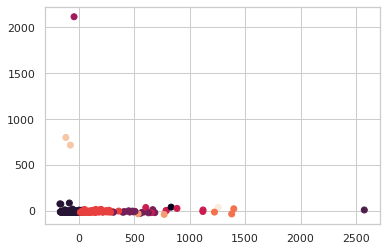

cluster: 0
['time']
cluster: 1
['solitons', 'p', 'hirota method', 'changes', 'increase', 'type', 'equation', 'symbolic computation', 'potential', 'equations', 'interaction', 'fields', 'n', 'influence', 'aim', 'result', 'errors', 'total', 'sample', 'validation', 'input', 'identification', 'objective', 'propagation', 'basis', 'conclusion', 'novel approach', 'people', 'purpose', 'target', 'patients', 'present study', 'subjects', 'objects', 'addition', 'computer graphics', 'response', 'effects', 'functions', 'researchers', 'need', 'estimation', 'example', 'operating systems', 'species', 'survey', 'patterns', 'way', 'visualization', 'characteristics', 'region', 'size', 'combination', 'prediction', 'opportunities', 'variables', 'distribution', 'john wiley', 'sons', 'areas', 'query', 'advantage', 'issues', 'parts', 'data structures', 'project', 'integration', 'services', 'mechanism', 'reduction', 'article', 'network security', 'devices', 'protocol', 'existing methods', 'energy consumption', '

In [34]:
kmeans_clustering(path, 11) #we test with 11 clusters as we have 11 core concepts

## Core-concept-based clustering test

For this test, we select two global words related to the computer science domain : "computer" and "information".  
We also add a more specialized value, "bioinformatics", to check if the biotech theme is detected.  

In [35]:
CoreConcepts = ['computer', 'information', 'bioinformatics']
core_concept_based_clustering(path, CoreConcepts)

cluster: computer
['computer graphics', 'computer vision', 'computer science', 'science', 'experience', 'learners', 'programming', 'computer programming', 'concepts', 'course', 'skills', 'students', 'teaching', 'education', 'games', 'difficulties', 'success', 'teachers']
cluster: information
['solitons', 'p', 'hirota method', 'changes', 'solutions', 'computation', 'increase', 'type', 'results', 'equation', 'symbolic computation', 'field', 'analysis', 'potential', 'equations', 'systems', 'method', 'system', 'applications', 'paper', 'communication', 'interaction', 'fields', 'design', 'n', 'influence', 'classification', 'aim', 'order', 'result', 'errors', 'approach', 'total', 'sample', 'features', 'validation', 'state', 'input', 'function', 'identification', 'objective', 'problem', 'art', 'algorithms', 'accuracy', 'propagation', 'basis', 'technique', 'conclusion', 'methods', 'network', 'novel approach', 'support', 'study', 'people', 'data', 'purpose', 'target', 'patients', 'subjects', 'ob

## OPTICS Clustering algorithm

First, we define a utility function that removes the unknown values : OPTICS returns a label equal to -1 when a value has no cluster.  

This function takes the matrix values, matrix labels, OPTICS output, and returns these three variables minus all elements located at the same index as a "-1" value in the OPTICS result.

In [36]:
def remove_unknown_values(matrix_values, matrix_labels, optics_output):

  #transform numpy ndarrays to dataframes -- matrix_labels is already a dataframe
  labeled_window_matrix = pd.concat([pd.DataFrame(matrix_values), pd.DataFrame(optics_output, columns=['label']), matrix_labels], axis=1)
  labeled_window_matrix = labeled_window_matrix[labeled_window_matrix.label != -1]

  #extract columns label and changes into independent variables
  optics_label_list_without_unknown_values = labeled_window_matrix['label'].values
  label_list_without_unknown_values = labeled_window_matrix['label_name'].values

  #drop columns label and changes to get only matrix values
  labeled_window_matrix.drop('label', axis=1, inplace=True)
  labeled_window_matrix.drop('label_name', axis=1, inplace=True)

  return labeled_window_matrix.values, label_list_without_unknown_values, optics_label_list_without_unknown_values

#test
# Xtest = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",")
# matrix_labels = pd.read_csv(path+"/OutputDir/window_matrix_terms.txt", delimiter=",")
# remove_unknown_values(Xtest, matrix_labels, optics_output)

Then we create the function `optics_clustering` which will perform the OPTICS clustering algorithm on the dataset.  
We use default values :  
*   epsilon set to infinity
*   min_samples = 5 (5 samples are needed to create a new cluster)

The function load the co-occurence matrix, performs PCA to reduce dimension from 400+ to only 2 to help fight against sparsity.  

Then, the data is fed to OPTICS for fitting. When a value is part of a cluster, it gets a cluster id. All data that failed identification is labelled with "-1" value.  

Then, to have a graph with useful information, we filter-out the unknown samples and display a scatter plot of similar terms. They are colored by cluster id.  

To chekc wether the cluster contents make sense, we also return a dataframe with all the cluster as rows and a unique column containing all the true labels (the co-occurence matrix terms) grouped by cluster.

Unknown Values : 38
Values part of a cluster : 431
How many clusters found : 1


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


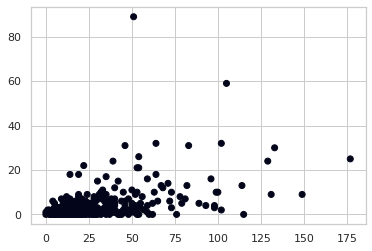

,clusters
0,"{classification, efficiency, big data, step, simulation, quality, output, advantages, solitons, attributes, level, surface, better performance, novel method, aim, p, techniques, query, use, limitations, order, set, aspects, account, overview, hirota method, changes, proposal, group, terms, reliability, mobile devices, comparison, construction, platform, fact, requirements, findings, focus, events, power, applicability, people, wide range, length, lot, computation, cryptography, methodology, proposed model, result, cells, sequence, increase, task, difference, theory, precision, effect, functions, advantage, means, errors, concepts, new method, extension, issue, gpus, tests, investigation, solution, same time, genetic algorithm, relation, years, real time, code, attacks, view, sense, differences, capability, storage, levels, characteristics, genes, presence, purpose, software development, class, target, gpu, distance, mechanism, region, work, usage, wireless sensor networks, type, kind, ...}"


In [37]:
def optics_clustering(path, pca_on=True):
       
  #load the data
  X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",")

  # perform PCA
  if pca_on:
    X = PCA(n_components=2).fit_transform(X)
  
  #run OPTICS clustering
  db = OPTICS(min_samples=5).fit(X)

  #get the identified labels
  cluster_groups = db.labels_

  #load the true labels
  matrix_labels = pd.read_csv(path+"/OutputDir/window_matrix_terms.txt", delimiter=",", names=['label_name'])

  #filter "-1" values, AKA unknow values
  X, matrix_labels, cluster_labels = remove_unknown_values(X,matrix_labels, cluster_groups)

  #display some stats
  print("Unknown Values : "+str(len(cluster_groups)-len(cluster_labels)))
  print("Values part of a cluster : "+str(len(cluster_labels)))
  print("How many clusters found : "+str(len(set(cluster_labels))))
  print('\n')

  print(cluster_labels)
  
  plt.figure()
  plt.scatter(X[:, 0], X[:, 1], c=cluster_labels)
  plt.show()

  #return a dataframe with the true labels associated to the clusters found by OPTICS
  cluster_and_matrix_labels_df = pd.concat([pd.DataFrame(matrix_labels, columns=['clusters']), pd.DataFrame(cluster_labels, columns=['cluster_labels'])], axis=1)
  cluster_and_matrix_labels_df = cluster_and_matrix_labels_df.groupby(['cluster_labels'], as_index=False).agg(lambda col: set(col))
  cluster_and_matrix_labels_df.drop('cluster_labels', axis=1, inplace=True)
  cluster_and_matrix_labels_df

  return cluster_and_matrix_labels_df

#test without PCA
optics_clustering(path, False)

As we can see below, the PCA improves greatly accuracy and sample identification by counteracting matrix sparsity

Unknown Values : 203
Values part of a cluster : 266
How many clusters found : 27


[ 0 11 23 20 13 26  9 19 26 25 26 18 12 22  9 24 16  3  4 23 23 13 19 10
 25 25 25  1 10 22  8 20 25 13 23 17 11 25  9 17 10 22 15 18 12 24 25 19
 18 17 25 10 23 19 26  7 16 24 13  0 17 11 12 23 13 18 21 13 24 19 16 15
  8  5 22 25 24 10 15 25  7 20 24 24  4 22  3  4 12  9 16  0 16 25 15 20
  9 13 18 10 14 16 21 21  5  9  2 20 23  0  6 14 19  0  2 16 20 14 22  5
 15  9  5 23 19  8  1 26  0 13 12 23 21  9  7 23 25 10  6 18 15 18 19 19
  3  5  0  3  6 17  8 18  0  1  5 16 24 11  7 24  2 15  9 21 17 11 22 18
 17  5  8 14  0  9 13 24 20  3 18 18 21  1 16  0 10  3 10  5  5 10  4  8
 23  9 13 10  4  7  4 20  8  8  0 15  4 14  6  1 11 11  1 14 11  4 20 13
 10  8 18  4  2 10  0 13  6  0  8  0  4 10  8  8  5 20  0  3 12  9 11  0
  4  0  0  8  8  8  1  2  7  6  5  4  8  8  0  8  8  6  8  8  8  2  8  8
  8  6]


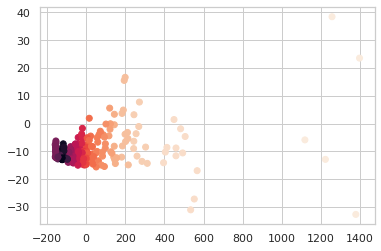

,clusters
0,"{p, idea, classes, software development, limitations, attributes, attention, sensors, experience, developers, parts, events, contrast, clusters, evidence, account, skills, kind, position}"
1,"{degree, cells, propagation, prototype, case study, location, respect}"
2,"{lack, steps, findings, nature, benefits, privacy}"
3,"{errors, line, risk, volume, interest, node, measurements}"
4,"{sequences, advantages, genes, collection, background, sample, mechanisms, classifier, aspects, simulation results, server, samples}"
5,"{presence, contribution, energy consumption, participants, extension, proposal, computers, wide range, ways, flexibility, large number}"
6,"{fact, objectives, computer science, observations, edges, sdn, mobile devices, recent years}"
7,"{aid, difficulties, same time, opportunities, variation, learners}"
8,"{important role, existing methods, magnitude, insight, new approach, introduction, proposed framework, place, things, novel method, majority, novel approach, individuals, other hand, date, extensive experiments, wireless sensor networks, proposed system, previous work, difficulty, lot, wsns, consideration, overview, possibility}"
9,"{goal, elements, factors, needs, understanding, challenge, sequence, response, rules, series, symbolic computation, aim}"


In [38]:
optics_clustering(path)

## Gold ontology statistics

In this subsection, we show some statistics about the gold standard.

First, the class distribution ordered by class id :

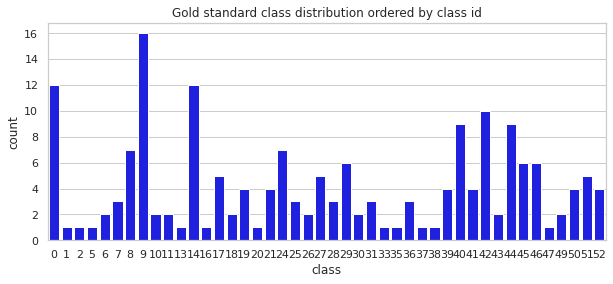

In [39]:
#open gold standard
gold_standard = pd.read_csv(path+'/InputDir/goldsorted.csv', sep=',')
gold_standard.drop('Unnamed: 0', inplace=True, axis=1)
gold_standard_counts = gold_standard.value_counts().to_frame().reset_index()


gold_standard_counts = gold_standard.ToCoreConcept.value_counts().to_frame().reset_index()
gold_standard_counts.columns =['class', 'count']

plt.figure(figsize=(10,4))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="class", y="count", data=gold_standard_counts, color='blue')
plt.title('Gold standard class distribution ordered by class id')
plt.show()

Next, we plot the same class count distribution but ordered by class count :

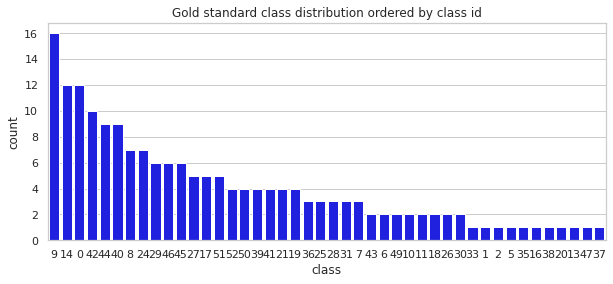

In [40]:
#sort dataframe by class counts
gold_standard_counts = gold_standard_counts.sort_values('count', ascending=False)

#string conversion of class column to prevent the ordering of the x axis by numeric value
gold_standard_counts["class"] = (gold_standard_counts["class"].astype(str)) 

plt.figure(figsize=(10,4))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="class", y="count", data=gold_standard_counts, color='blue')
plt.title('Gold standard class distribution ordered by class id')
plt.show()

For the next graph, we will need to create a silver standard by matching subcategories to core-categories :

In [41]:
gold_standard = pd.read_csv(path+'/InputDir/goldsorted.csv', sep=',')
gold_standard.drop('Unnamed: 0', inplace=True, axis=1)

ontology_categories = pd.read_csv(path+'/TP_CS_CoreConceptIn2Level.csv', sep=',')
ontology_categories = ontology_categories.rename(columns={'Unnamed: 0':'id'})

core_categories = ontology_categories[['level1_13CoreConcepts']].groupby('level1_13CoreConcepts', as_index=False).sum()

gold_standard_counts = gold_standard.ToCoreConcept.value_counts().to_frame().reset_index()
gold_standard_counts.columns =['ToCoreConcept', 'count']

gold_standard_counts['core_cat'] = gold_standard_counts.apply(lambda row: ontology_categories.iloc[row['ToCoreConcept']]['level1_13CoreConcepts'], axis=1)
gold_standard_counts['core_cat'] = gold_standard_counts.apply(lambda row: core_categories[core_categories.level1_13CoreConcepts == row['core_cat']].index.values[0], axis=1)


gold_standard_counts

,ToCoreConcept,count,core_cat
0,9,16,1
1,0,12,3
2,14,12,11
3,42,10,4
4,44,9,4
5,40,9,0
6,8,7,1
7,24,7,9
8,29,6,9
9,46,6,6


Then, we plot the gold standard (core-concepts replace sub-core-concepts) as a hue over the original count plot (ordered by id) :

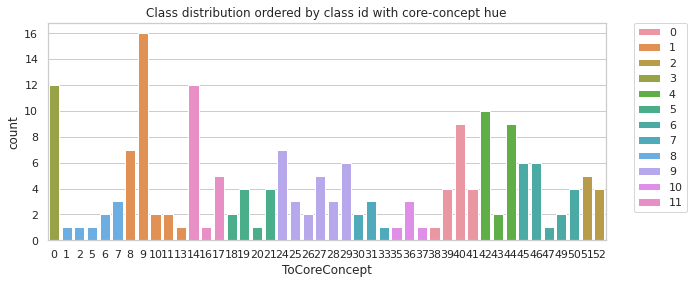

In [42]:
plt.figure(figsize=(10,4))
tips = sns.load_dataset("tips")
ax = sns.barplot(data=gold_standard_counts, x="ToCoreConcept", y="count", hue='core_cat', dodge=False)
plt.title('Class distribution ordered by class id with core-concept hue')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

As we can see, all core-concepts are not equally represented in the gold standard as some of them have 4 sub-core-categories (like the ids 1 to 7) while others are represented by only one class (eg. id 0).

To obtain the silver standard, we group the previous gold standard by core-concept ids :

In [43]:
silver_standard_counts = gold_standard_counts[['count', 'core_cat']].groupby('core_cat', as_index=False).sum()
silver_standard_counts

,core_cat,count
0,0,18
1,1,28
2,2,9
3,3,12
4,4,21
5,5,11
6,6,19
7,7,6
8,8,8
9,9,26


We can then plot the same graphs : first the class count distribution ordered by class id :

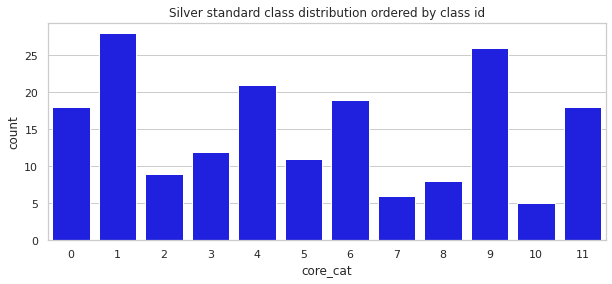

In [44]:
plt.figure(figsize=(10,4))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="core_cat", y="count", data=silver_standard_counts, color='blue')
plt.title('Silver standard class distribution ordered by class id')
plt.show()

Then we plot the silver standard class distribution ordered by class count :

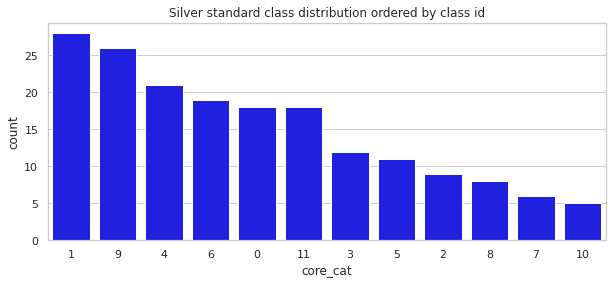

In [45]:
#sort dataframe by class counts
silver_standard_counts = silver_standard_counts.sort_values('count', ascending=False)

#string conversion of class column to prevent the ordering of the x axis by numeric value
silver_standard_counts["core_cat"] = (silver_standard_counts["core_cat"].astype(str)) 

plt.figure(figsize=(10,4))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="core_cat", y="count", data=silver_standard_counts, color='blue')
plt.title('Silver standard class distribution ordered by class id')
plt.show()

We still observe a class imbalance, with class 1 being 5 times more represented than class 10, but all the classes are represented at least 5 times.  
From there, we have 2 choices to correct the dataset : 
*   we can cut all classes below 10 to ensure a more balanced training but will lose half of the classes
*   we can limit all classes to 5 samples in the training set, with the least represented classes suffering from overfitting from the test dataset perspective.

## KNN test

### Gold standard fitting

Before running KNN, we need to add core-concept sub-categories to the label list (fit the gold standard to our current data).

Steps :
1. import gold standard to map subcategories to int id
2. map window_matrix_terms file to gold stadard ids with category matching
3. save a window_matrix_terms_labeled file with comma separated terms and labels


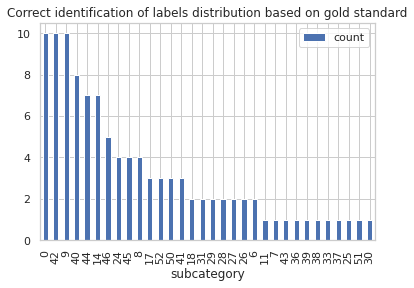

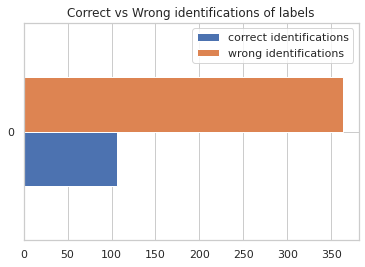

In [46]:
def match_extracted_terms_to_gold_standard(path):
  
  #open the matrix terms
  window_matrix_terms_df = pd.read_csv(path+'/OutputDir/window_matrix_terms.txt', sep=',', names=['fields'])

  #open gold standard
  gold_standard = pd.read_csv(path+'/InputDir/goldsorted.csv', sep=',')
  gold_standard.drop('Unnamed: 0', inplace=True, axis=1)

  #apply matching between matrix terms and go standard
  window_matrix_terms_df['cat_id'] = window_matrix_terms_df.apply(lambda row: gold_standard[gold_standard.Term == row['fields']].ToCoreConcept.values[0] if (row['fields'] in gold_standard.Term.unique()) else -1, axis=1)

  #save results to window_matrix_terms_labeled file
  window_matrix_terms_df.to_csv(path+"/InputDir/window_matrix_terms_labeled.txt", sep=",", header=False, index=False)

  #return a recap of label matches
  recap_df = window_matrix_terms_df.cat_id.value_counts().to_frame().reset_index()
  recap_df.columns = ['subcategory', 'count']
  return recap_df

#execute function and show first 5 lines of attribution recap : -1 means that ontology didn't match
recap_df = match_extracted_terms_to_gold_standard(path)

#plot bar graph of match count distribution over categories
correct_ids = recap_df[recap_df.subcategory > -1]
correct_ids.plot(kind='bar', title='Correct identification of labels distribution based on gold standard', x='subcategory')

#plot count of matches against "total minus matches" count
pd.DataFrame([[correct_ids['count'].sum(), recap_df['count'].sum() - correct_ids['count'].sum()]], columns=['correct identifications', 'wrong identifications']).plot(kind='barh', title='Correct vs Wrong identifications of labels')

Finally we run KNN :

KNN is not the supervised algorithm that we will focus on so we only check accuracy and a few results in the prediction list. We can see that the "-1" value is often predicted because most of the values in the fitted gold standard are not in the original gold standard.  

For the SVM test, we will only use known values for the training step in order to correct this "-1" imbalance.  
We will as well check the balance of known values against each other.  

In [47]:
KNN(path)

accuracy:
0.7872340425531915
probability, -1, -1
number, -1, 37
algorithms, -1, -1
properties, -1, 0
testing, -1, -1
architecture, -1, -1
platform, -1, -1
samples, -1, -1
data, 50, -1
factors, -1, -1
different types, -1, -1
target, -1, -1
science, -1, -1
mobile devices, 17, -1
cost, -1, -1
work, -1, -1
possibility, -1, -1
correctness, -1, -1
sensors, -1, -1
tasks, -1, -1
authors, -1, -1
feasibility, -1, -1
individuals, -1, -1
complexity, -1, -1
field, -1, -1
programming, 42, -1
kinds, -1, -1
interactions, -1, -1
execution, -1, -1
motion, 0, -1
structure, -1, -1
systems, -1, -1
protocols, -1, -1
investigation, -1, -1
network security, -1, -1
application, 24, -1
other hand, -1, -1
function, -1, 36
identification, 9, -1
review, -1, -1
areas, -1, -1
task, -1, -1
conditions, 42, -1
computer, -1, -1
sets, -1, -1
influence, -1, -1
devices, -1, 14
validity, -1, -1
processes, -1, -1
real time, 17, -1
detection, 9, -1
cloud, 50, -1
magnitude, -1, -1
mechanisms, -1, -1
notion, -1, -1
creation, -1

## SVM test

`remove_labels_not_found_in_gold_standard` is a utility function used in the SVM function. It removes "-1" values from the fitted gold standard to correct class imbalance.

In [48]:
def remove_labels_not_found_in_gold_standard(X, Y):
  
  XY = pd.concat([pd.DataFrame(Y, columns=['label_name', 'core_id']), pd.DataFrame(X)], axis=1)
  XY = XY[XY.core_id != '-1']

  Y = XY[['label_name', 'core_id']]

  X = XY.drop(['label_name', 'core_id'], axis=1)

  return X.values, Y.values

#test
# Xtest = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",", dtype=float)
# Ytest = np.loadtxt(path+"/InputDir/window_matrix_terms_labeled.txt", delimiter=",", dtype=str)
# remove_labels_not_found_in_gold_standard(Xtest, Ytest)

SVM : We display accuracy, some predictions against their correct values, and a confusion matrix as well.

Training set size : 106
accuracy : 0.03125


developers, 43, 0
hardware, 14, 0
communication, 17, 0
knowledge, 8, 0
visualization, 0, 0
internet, 14, 0
size, 44, 0
components, 24, 0
training, 9, 0
simulation, 26, 0
big data, 50, 0
learners, 9, 0
conditions, 42, 0
parameters, 42, 0
model, 45, 0
nodes, 46, 0
device, 31, 0
software development, 27, 0
series, 41, 0
gpu, 7, 0
genes, 52, 0
effectiveness, 44, 0
cloud, 50, 0
class, 42, 0
functions, 41, 0
understanding, 8, 0
distribution, 40, 0
errors, 24, 0
means, 40, 0
detection, 9, 0
mobile devices, 17, 0
noise, 40, 0


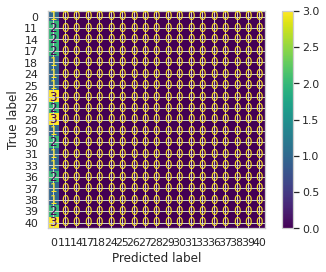

In [49]:
def svm_function(path, details=True):
  import numpy as np
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import recall_score
  # from sklearn.metrics import pre
  from sklearn.svm import SVC

  #load the data and labels
  X = np.loadtxt(path+"/OutputDir/window_matrix.csv", delimiter=",", dtype=float)
  Y = np.loadtxt(path+"/InputDir/window_matrix_terms_labeled.txt", delimiter=",", dtype=str)

  #remove labels not found in gold standard
  X, Y = remove_labels_not_found_in_gold_standard(X, Y)

  

  #split the data between training and testing
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import plot_confusion_matrix
  data_train, data_test, labels_train, labels_test, couples_train, couples_test = train_test_split(X, Y[:, 1], Y[:, 0], test_size=0.30)

  clf = SVC(gamma='auto')
  clf.fit(data_train, labels_train)

  #predict for the testing data
  y = clf.predict(data_test)
  #pring the results
  accuracy_score_value = accuracy_score(labels_test, y)

  if details:
    plot_confusion_matrix(clf, data_test, labels_test)
    print('Training set size : '+str(len(X)))
    print ("accuracy : " + str(accuracy_score_value))
    print('\n')
    i = 0
    for couple in couples_test:
      if int(y[i]) - int(labels_test[i]) == 0:
          print(couple + ", " + str(labels_test[i]) + ", " + str(y[i]))
      else:
          print(couple + ", " + str(labels_test[i]) + ", " + str(y[i]))
      i += 1
  else:
    return accuracy_score_value, recall_score(labels_test, y, average='macro')

svm_function(path)

Next, we see that the dataset split affects SVM performance (because of class imbalance and a small number of samples).  

To get a better appreciation of the real accuracy (as well as recall), we train SVM a 100 times and store the result.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and 

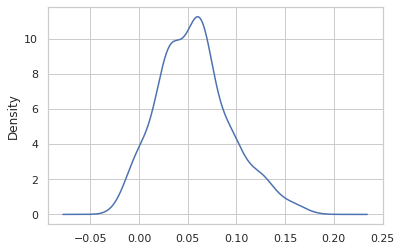

In [50]:
iteration_accuracy = []
for run_iteration in tq.tqdm(range(0, 100)):
  accuracy_value, recall_value = svm_function(path, details=False)
  iteration_accuracy.append(['gold_standard', accuracy_value, recall_value])

iteration_accuracy_df = pd.DataFrame(iteration_accuracy, columns=['standard_name', 'accuracy', 'recall'])
iteration_accuracy_df.accuracy.plot(kind='kde')

### Silver standard fitting

We can see that the accuracy is very bad. We need more matching in our reference dataset. The gold standard matches terms to sub-core-categories.  

Lets code a silver standard that matches terms to core-categories (the top 10 categories) :

            fields  cat_id
0    solitons      -1     
1    p             -1     
2    hirota method -1     
3    changes       -1     
4    solutions     -1     
..         ...     ..     
464  overview      -1     
465  novel method  -1     
466  things        -1     
467  existence     -1     
468  sdn            11    

[469 rows x 2 columns]


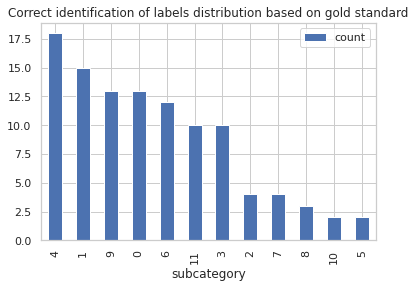

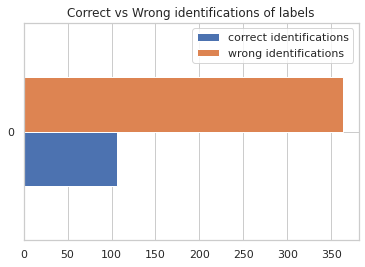

In [51]:
def match_extracted_terms_to_silver_standard(path):
  
  #open the matrix terms
  window_matrix_terms_df = pd.read_csv(path+'/OutputDir/window_matrix_terms.txt', sep=',', names=['fields'])

  #open gold standard
  gold_standard = pd.read_csv(path+'/InputDir/goldsorted.csv', sep=',')
  gold_standard.drop('Unnamed: 0', inplace=True, axis=1)

  ontology_categories = pd.read_csv(path+'/TP_CS_CoreConceptIn2Level.csv', sep=',')
  ontology_categories = ontology_categories.rename(columns={'Unnamed: 0':'id'})

  core_categories = ontology_categories[['level1_13CoreConcepts']].groupby('level1_13CoreConcepts', as_index=False).sum()

  gold_standard['ToCoreConcept'] = gold_standard.apply(lambda row: ontology_categories.iloc[row['ToCoreConcept']]['level1_13CoreConcepts'], axis=1)
  gold_standard['ToCoreConcept'] = gold_standard.apply(lambda row: core_categories[core_categories.level1_13CoreConcepts == row['ToCoreConcept']].index.values[0], axis=1)

  #apply matching between matrix terms and gold standard
  window_matrix_terms_df['cat_id'] = window_matrix_terms_df.apply(lambda row: gold_standard[gold_standard.Term == row['fields']].ToCoreConcept.values[0] if (row['fields'] in gold_standard.Term.unique()) else -1, axis=1)

  print(window_matrix_terms_df)

  #save results to window_matrix_terms_labeled file
  window_matrix_terms_df.to_csv(path+"/InputDir/window_matrix_terms_labeled.txt", sep=",", header=False, index=False)

  #return a recap of label matches
  recap_df = window_matrix_terms_df.cat_id.value_counts().to_frame().reset_index()
  recap_df.columns = ['subcategory', 'count']
  return recap_df

#execute function and show first 5 lines of attribution recap : -1 means that ontology didn't match
recap_df = match_extracted_terms_to_silver_standard(path)

#plot bar graph of match count distribution over categories
correct_ids = recap_df[recap_df.subcategory > -1]
correct_ids.plot(kind='bar', title='Correct identification of labels distribution based on gold standard', x='subcategory')

#plot count of matches against "total minus matches" count
pd.DataFrame([[correct_ids['count'].sum(), recap_df['count'].sum() - correct_ids['count'].sum()]], columns=['correct identifications', 'wrong identifications']).plot(kind='barh', title='Correct vs Wrong identifications of labels')

Training set size : 106
accuracy : 0.15625


gpu, 8, 4
conditions, 4, 4
computation, 4, 4
device, 7, 4
noise, 0, 4
networks, 11, 4
proteins, 2, 4
contrast, 3, 4
sequences, 2, 4
surface, 0, 4
information, 1, 4
internet, 11, 4
sdn, 11, 4
distribution, 0, 4
optimization, 0, 4
sequence, 2, 4
uncertainty, 0, 4
combination, 4, 4
application, 9, 4
cpu, 9, 4
set, 6, 4
detection, 1, 4
errors, 9, 4
programming, 4, 4
code, 4, 4
focus, 3, 4
software development, 9, 4
nodes, 6, 4
motion, 3, 4
range, 0, 4
wsns, 11, 4
learners, 1, 4


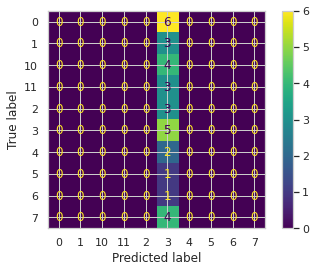

In [52]:
svm_function(path)

We plot the accuracy of gold standard VS silver standard trained SVMs and the silver standard is better. This can be attributed to a higher class count.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'SVM accuracy comparison between sub-core-concept matching and core-concept matching')

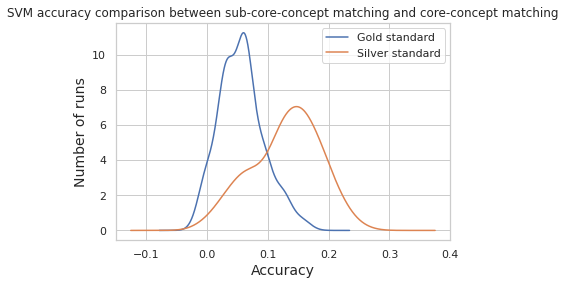

In [53]:
for run_iteration in tq.tqdm(range(0, 100)):
  accuracy_value, recall_value = svm_function(path, details=False)
  iteration_accuracy.append(['silver_standard', accuracy_value, recall_value])

iteration_accuracy_df = pd.DataFrame(iteration_accuracy, columns=['standard_name', 'accuracy', 'recall'])



fig, ax = plt.subplots()
iteration_accuracy_df[iteration_accuracy_df.standard_name == 'gold_standard'].accuracy.plot(kind='kde', ax=ax)
iteration_accuracy_df[iteration_accuracy_df.standard_name == 'silver_standard'].accuracy.plot(kind='kde', ax=ax)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Number of runs', fontsize=14)
ax.legend(["Gold standard", "Silver standard"])
plt.title('SVM accuracy comparison between sub-core-concept matching and core-concept matching')

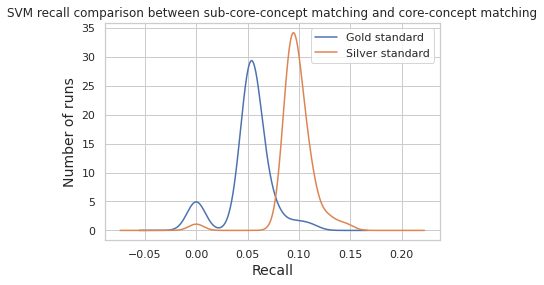

In [54]:
fig, ax = plt.subplots()
iteration_accuracy_df[iteration_accuracy_df.standard_name == 'gold_standard'].recall.plot(kind='kde', ax=ax)
iteration_accuracy_df[iteration_accuracy_df.standard_name == 'silver_standard'].recall.plot(kind='kde', ax=ax)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Number of runs', fontsize=14)
ax.legend(["Gold standard", "Silver standard"])
plt.title('SVM recall comparison between sub-core-concept matching and core-concept matching')
plt.show()